In [1]:
!pip install -q kaggle

In [2]:
import shutil
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d trolukovich/apparel-images-dataset

100% 247M/248M [00:15<00:00, 20.0MB/s]
100% 248M/248M [00:15<00:00, 16.4MB/s]


In [6]:
import zipfile
import os

with zipfile.ZipFile("apparel-images-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("apparel-images-dataset")

In [7]:
# memverifikasi bahwa file telah diekstrak
base_dir = 'apparel-images-dataset'
print(os.listdir(base_dir))

['blue_shorts', 'green_shirt', 'green_shorts', 'white_dress', 'red_shoes', 'white_shorts', 'black_shoes', 'red_dress', 'white_shoes', 'blue_dress', 'white_pants', 'blue_shoes', 'blue_shirt', 'blue_pants', 'brown_shoes', 'black_dress', 'black_shirt', 'black_shorts', 'brown_shorts', 'green_shoes', 'brown_pants', 'green_pants', 'black_pants', 'red_pants']


In [8]:
# fungsi menghitung jumlah data untuk setiap kelas
def count_data(directory):
    return len(os.listdir(directory))

In [9]:
classes = ['blue_pants', 'white_shoes', 'white_dress', 'blue_shorts', 'blue_shirt', 'blue_shoes', 'red_pants', 'black_pants', 'brown_shoes', 'white_pants', 'black_shorts', 'white_shorts', 'green_shirt', 'black_shoes', 'black_dress', 'green_shorts', 'blue_dress', 'black_shirt', 'red_shoes', 'green_pants', 'green_shoes', 'brown_pants', 'brown_shorts', 'red_dress']
totals = {cls: count_data(os.path.join(base_dir, cls)) for cls in classes}

In [10]:
# mencetak jumlah data untuk setiap kelas
for cls, total in totals.items():
    print(f"Total Data {cls} Image: {total}")

Total Data blue_pants Image: 798
Total Data white_shoes Image: 600
Total Data white_dress Image: 818
Total Data blue_shorts Image: 299
Total Data blue_shirt Image: 741
Total Data blue_shoes Image: 523
Total Data red_pants Image: 308
Total Data black_pants Image: 871
Total Data brown_shoes Image: 464
Total Data white_pants Image: 274
Total Data black_shorts Image: 328
Total Data white_shorts Image: 120
Total Data green_shirt Image: 230
Total Data black_shoes Image: 766
Total Data black_dress Image: 450
Total Data green_shorts Image: 135
Total Data blue_dress Image: 502
Total Data black_shirt Image: 715
Total Data red_shoes Image: 610
Total Data green_pants Image: 227
Total Data green_shoes Image: 455
Total Data brown_pants Image: 311
Total Data brown_shorts Image: 40
Total Data red_dress Image: 800


In [11]:
# generator untuk augmentasi gambar & data train/validasi
val_size = 0.2
image_size = (150, 150)


In [12]:
datagen = ImageDataGenerator(
    rotation_range=30,
    brightness_range=[0.2, 1.0],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    rescale=1./255,
    validation_split=val_size
)

generator_params = dict(
    target_size=image_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=True
)

In [13]:
train_generator = datagen.flow_from_directory(
    base_dir,
    subset="training",
    classes=classes,
    **generator_params
)

val_generator = datagen.flow_from_directory(
    base_dir,
    subset="validation",
    classes=classes,
    **generator_params
)

Found 9115 images belonging to 24 classes.
Found 2270 images belonging to 24 classes.


In [14]:
# pembuatan model dengan output layer sesuai dengan jumlah kelas baru
num_classes = len(classes)

In [15]:
# pembuatan model image classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=3),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=3),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=3),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 148, 148, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                        

In [16]:
# penggunaan callbacks
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5',
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
callbacks = [early_stopping, reduce_lr, checkpointer]

In [17]:
# melatih model
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 2.0559 - accuracy: 0.4136
Epoch 1: val_accuracy improved from -inf to 0.02423, saving model to saved_models/model_vanilla.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 135s 2s/step - loss: 2.0559 - accuracy: 0.4136 - val_loss: 8.1166 - val_accuracy: 0.0242 - lr: 0.0010
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 1.2680 - accuracy: 0.6134
Epoch 2: val_accuracy improved from 0.02423 to 0.02687, saving model to saved_models/model_vanilla.hdf5
72/72 [==============================] - 107s 1s/step - loss: 1.2680 - accuracy: 0.6134 - val_loss: 9.0732 - val_accuracy: 0.0269 - lr: 0.0010
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 1.0277 - accuracy: 0.6812
Epoch 3: val_accuracy improved from 0.02687 to 0.06784, saving model to saved_models/model_vanilla.hdf5
72/72 [==============================] - 105s 1s/step - loss: 1.0277 - accuracy: 0.6812 - val_loss: 6.7293 - val_accuracy: 0.0678 - lr: 0.0010
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.9036 - accuracy: 0.7231
Epoch 4: val_accuracy improved from 0.06784 to 0.16828, saving model to saved_mod

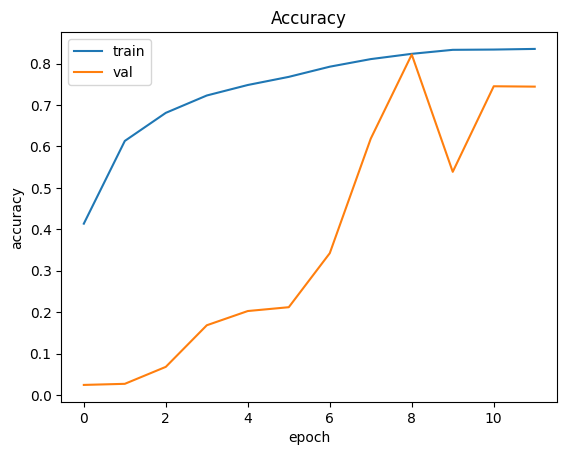

In [18]:
# membuat visualisasi plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

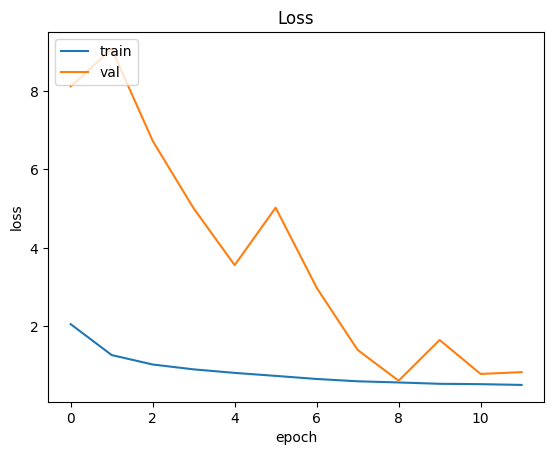

In [19]:
# membuat visualisasi plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# menkonversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


In [21]:
# menyimpan model TFLite
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)